# A simple logistic regression classifier

In [1]:
import numpy as np
from numpy.linalg import LinAlgError
import matplotlib.pyplot as plt
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect
import math
#import sckit-learn logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns



from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio, get_val_data

/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda


In [2]:
trainA = "upperTriA" #"unifA" #"gaussA" #"gaussA_noscale" #"rotDiagA" #"rotDiagA_unif" #"rotDiagA_gauss" #"upperTriA" #"single_system" #"cond_num" #"mix_gauss_upptri_rotdiag"
valA = "upperTriA" #"unifA" #"gaussA" #"gaussA_noscale" #"rotDiagA" #"rotDiagA_unif" #"rotDiagA_gauss" #"upperTriA" #"single_system" #"cond_num"
num_val_systems = 1000
context_len = 250
nx = 20
print("nx:", nx)

print('context_len:', context_len)
print('trainA:', trainA)
print('valA:', valA)
print("num_val_systems:", num_val_systems)
C_dist = "_gauss_C" #"_unif_C" #"_gauss_C" #"_gauss_C_large_var" #"_single_system"
# experiments = ["241121_182725.0ad317_upperTriA_state_dim_3_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241124_004016.7a9db9_upperTriA_state_dim_20_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241124_025241.7a9db9_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_40000"]#, "241107_233959.102bf2_gaussA_gauss_C_mix_lr_0"]#, "241117_204226.922f5f_rotDiagA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000"]
# print("experiment strings:", experiments)

nx: 20
context_len: 250
trainA: upperTriA
valA: upperTriA
num_val_systems: 1000


In [3]:
def pairwise_mul(array, n):
    ydim = array.shape[1]
    # Step 1: Slice the array to take the first n elements along axis 0
    sliced_array = array[:n, :]

    # Step 2: Flatten the sliced array
    flattened_array = sliced_array.flatten()

    # Step 3: Reshape the flattened array to shape (5n, 1)
    reshaped_array = flattened_array.reshape(ydim * n, 1)

    outer = reshaped_array@reshaped_array.T

    flatten_out = outer.flatten()
    return flatten_out

#### Create the training examples through Pairwise Multiplication (still need to implement train-test split)

In [32]:
num_samples = (2*2000*1000) #2 classes, 2000 traces, 1000 systems
num_train_samples = np.floor(num_samples*0.75)
num_test_samples = num_samples - num_train_samples
print("total", num_samples)
print("train", num_train_samples)

d = 10 # Number of elements to take from axis 0

nxs = [10]
experiments = ["241210_180753.5991f3_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241203_014212.9ee182_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_120000"]
valAs = ["gaussA", "upperTriA"]
x = []
x_test = []
class_zero_final_ind = []
for i in range(2): #classify first two experiments
    obs = get_val_data(valAs[i], C_dist,experiments[i] , nx=10)
    count = 0
    for trace in obs:
        if count < 0.5 * num_train_samples:
            x.append(pairwise_mul(trace, d))
            if count + 1 >= 0.5 * num_train_samples:
                class_zero_final_ind.append(count)
        else:
            x_test.append(pairwise_mul(trace, d))

        count += 1
class_zero_final_ind.append(count - class_zero_final_ind[0])
x = np.array(x)
x_test = np.array(x_test)


train_set_size = x.shape #[num_train_samples x (ny*d)^2]
test_set_size = x_test.shape #[num_test_samples x (ny*d)^2]
print("train set size", train_set_size)
print("test set size", test_set_size)



total 4000000
train 3000000.0
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/241210_180753.5991f3_gaussA_state_dim_10_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/data/val_gaussA_gauss_C_state_dim_10.pkl
loaded state dim 10 validation obs
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/241203_014212.9ee182_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_120000/data/val_upperTriA_gauss_C_state_dim_10.pkl
loaded state dim 10 validation obs
train set size (3000000, 2500)
test set size (1000000, 2500)


In [ ]:
N = train_set_size[0]
N_test = test_set_size[0]


y = np.concatenate((np.zeros(int(N/2)), np.ones(int(N/2))))
x = np.concatenate((np.ones((N,1)),x),axis=1)

y_test = np.concatenate((np.zeros(int(N_test/2)), np.ones(int(N_test/2))))
x_test = np.concatenate((np.ones((N_test,1)),x_test),axis=1)

print("shape of x:", x.shape)
print("shape of y:", y.shape)
print("shape of x_test:", x_test.shape)
print("shape of y_test:", y_test.shape)

print(y[int(N/2)-1])
print(y[int(N/2)])
print(y[class_zero_final_ind[0]])
print(y[class_zero_final_ind[0]+1])


shape of x: (3000000, 2502)
shape of y: (3000000,)
shape of x_test: (1000000, 2501)
shape of y_test: (1000000,)
1.0
1.0
0.0
1.0


In [43]:
x = np.delete(x, 1, axis=1)
print("shape of x:", x.shape)
# compute the scores using sklearn logistic regression
clf = LogisticRegression()
clf.fit(x, y)



shape of x: (3000000, 2501)


LogisticRegression()

In [44]:
#get probabilities
probs = clf.predict_proba(x_test)

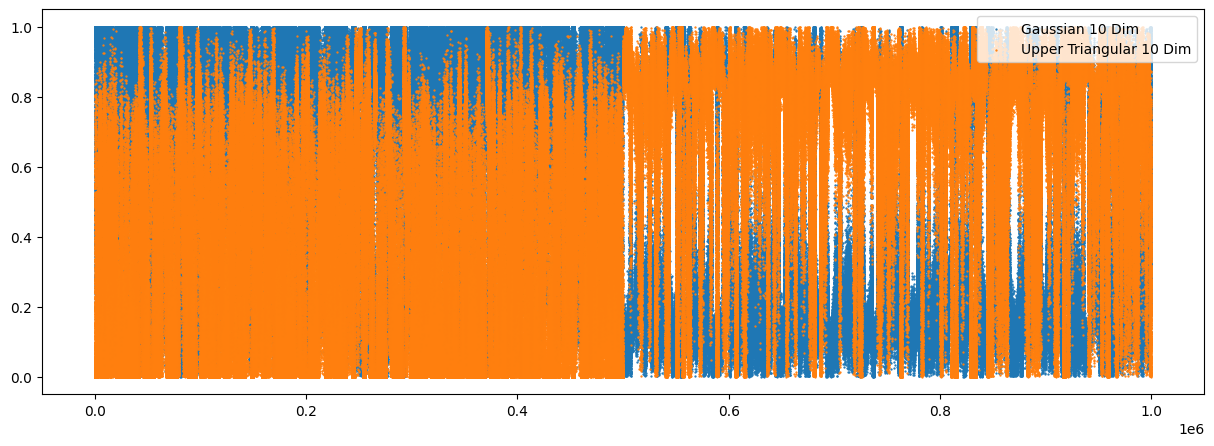

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))  # Width: 15, Height: 5
ax.scatter(range(len(y_test)), probs[:,0], label="Gaussian 10 Dim", s=0.4)
ax.scatter(range(len(y_test)), probs[:,1], label="Upper Triangular 10 Dim", s=0.4)
ax.legend(loc="upper right")
plt.show()

In [46]:
y_pred = clf.predict(x_test)



cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[361901, 138099],
       [ 86396, 413604]])

In [47]:
print("y_pred", y_pred)
print("y_test", y_test)

y_pred [0. 0. 0. ... 1. 0. 0.]
y_test [0. 0. 0. ... 1. 1. 1.]


Text(0.5, 427.9555555555555, 'Predicted label')

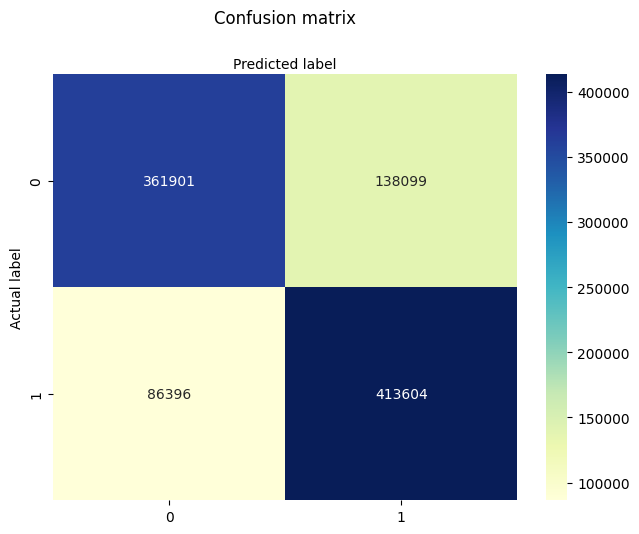

In [48]:
class_names=["Gaussian 10 Dim","Upper Triangular 10 Dim"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')